In [39]:
# set the directory to where the data is
import os

os.chdir(r"D:\Gene_Project")

In [40]:
# pandas for dealing with the data
import pandas as pd
# setting for seeing the entire string
pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', 500)

In [41]:
# load the data - new data that was provided
data = pd.read_csv(r"pul_seq_low_high_substr_year_corrected.csv")

In [42]:
data.head()

PULid                                                      sig_gene_seq  \
0  PUL0001  GH1,8.A.49,CE2,GH130,GH130,3.A.1,3.A.1,SBP_bac_1,LacI,GH36,GH113   
1  PUL0002                                                              GH16   
2  PUL0003                                               GH30_8,GH43_16|CBM6   
3  PUL0004                                                         4.A.1,GH1   
4  PUL0005                                                          GH94,GH3   

                      low_level_substr    high_level_substr Pub_year  
0                          beta-mannan          beta-mannan     2019  
1                             lichenan         beta-glucan      1996  
2                                xylan                xylan     2016  
3           glucose,cellobiose,maltose  multiple_substrates     2016  
4  beta-glucan,sophorose,laminaribiose  multiple_substrates     2016

In [43]:
from sklearn.pipeline import Pipeline

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
vectorizer_word = CountVectorizer(tokenizer=lambda x: str(x).replace("|", ",").split(','), lowercase = False)

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [48]:
selected_classes_high_level = ['capsule polysaccharide', 'algal glycans', 'xylan', 'pectin']

In [49]:
# selected_classes_low_level = ["O-glycan,N-glycan"]

In [50]:
selected_data_high_level = data[data["high_level_substr"].isin(selected_classes_high_level)]

In [51]:
# selected_data_high_level["high_level_substr"] = "known"

In [52]:
# selected_data_low_level = data[data["low_level_substr"].isin(selected_classes_low_level)]

In [53]:
part1 = selected_data_high_level[["sig_gene_seq", "high_level_substr"]]

In [54]:
# part2 = selected_data_low_level[["sig_gene_seq", "low_level_substr"]]

In [55]:
# part2.columns = ["sig_gene_seq", "high_level_substr"]

In [56]:
# part = pd.concat([part1, part2])

In [57]:
other_part = data.iloc[~data.index.isin(part1.index.tolist())]

In [58]:
other_part = other_part[["sig_gene_seq", "high_level_substr"]]

In [59]:
other_part["high_level_substr"] = "others"

In [60]:
combo = pd.concat([part1, other_part]).sample(frac = 1.0)

In [61]:
combo["high_level_substr"].value_counts()

others                    478
capsule polysaccharide     60
algal glycans              40
xylan                      38
pectin                     38
Name: high_level_substr, dtype: int64

In [62]:
from sklearn.model_selection import StratifiedKFold

In [63]:
skf = StratifiedKFold(n_splits=10)

In [64]:
import numpy as np

In [65]:
length = len(combo["high_level_substr"].value_counts())

In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
from sklearn.preprocessing import FunctionTransformer

In [68]:
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
cm1 = np.zeros((length, length))
unraveled_positions = []
for train_index, test_index in skf.split(combo["sig_gene_seq"], combo["high_level_substr"]):
    
    # fit the search
#     search = GridSearchCV(clf, param_grid, n_jobs=6 , verbose = 3, cv = 5, scoring = "balanced_accuracy")
    X_train, X_test = combo[["sig_gene_seq"]].iloc[train_index,:], combo[["sig_gene_seq"]].iloc[test_index,:]
    y_train, y_test = combo[["high_level_substr"]].iloc[train_index,:], combo[["high_level_substr"]].iloc[test_index,:]
    
    train_data = pd.concat([X_train, y_train],1).reset_index(drop = True)
    test_data = pd.concat([X_test, y_test],1).reset_index(drop = True)
    
    whole_classes = []
    whole_classes_proba = []
    for classes in np.unique(combo[["high_level_substr"]]):
        if classes != "others":
            clf = Pipeline([('vectorizer',CountVectorizer(tokenizer=lambda x: str(x).replace("|", ",").split(','), lowercase = False, 
                                             ngram_range=(1,2))),
                ('ft', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), 
#                 ('nca',NCA()), 
            ('brf',BalancedRandomForestClassifier())
            ])
            
            train_data_inner = train_data.copy()
#             test_data_inner = test_data.copy()
                           
            train_data_inner["high_level_substr"] = [1 if substr == classes else 0 for substr in train_data_inner["high_level_substr"]]
            clf.fit(train_data_inner["sig_gene_seq"], train_data_inner["high_level_substr"])               
        
            y_pred = clf.predict(test_data["sig_gene_seq"])
            y_pred_proba = clf.predict_proba(test_data["sig_gene_seq"])
#             test_data_inner["y_pred_" + classes] = y_pred
            test_data["y_pred_" + classes] = y_pred
            whole_classes.append("y_pred_" + classes)
            test_data["y_pred_" + classes + "_proba"] = y_pred_proba[:,1]
            whole_classes_proba.append("y_pred_" + classes + "_proba")
            test_data["pred_class_sum"] = test_data[whole_classes].sum(axis = 1)
            test_data["final_pred"] = [whole_classes[item].split("_")[-1] for item in test_data[whole_classes_proba].values.argmax(1).tolist()]
            test_data["pred_high_level_substr"] = ["others" if n == 0 else test_data["final_pred"][i] for i, n in enumerate(test_data["pred_class_sum"])]


    cm = confusion_matrix(test_data["high_level_substr"],
                                  test_data["pred_high_level_substr"], normalize = 'true', 
                                 labels = np.unique(combo[["high_level_substr"]]).tolist())
#             df_cm = pd.DataFrame(cm, index = [i for i in np.unique(combo[["high_level_substr"]]).tolist()],
#                   columns = [i for i in np.unique(combo[["high_level_substr"]]).tolist()])
    
    unraveled_positions.append(cm.ravel().tolist())
    
    cm1 += cm  

C:\Users\vedpi\AppData\Local\Temp/ipykernel_9544/1997360951.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  train_data = pd.concat([X_train, y_train],1).reset_index(drop = True)
C:\Users\vedpi\AppData\Local\Temp/ipykernel_9544/1997360951.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  test_data = pd.concat([X_test, y_test],1).reset_index(drop = True)
C:\Users\vedpi\AppData\Local\Temp/ipykernel_9544/1997360951.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  train_data = pd.concat([X_train, y_train],1).reset_index(drop = True)
C:\Users\vedpi\AppData\Local\Temp/ipykernel_9544/1997360951.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  test_data = pd.concat([X_test, y_

In [71]:
from sklearn.metrics import confusion_matrix

In [72]:
# get the array oaf confusion matrix
cm = cm1/10

# dataframe for confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in combo["high_level_substr"].value_counts().keys().tolist()],
                  columns = [i for i in combo["high_level_substr"].value_counts().keys().tolist()])

In [80]:
# average accuracy averaged over the classes
np.diag(df_cm).mean()

0.7489716312056738

In [73]:
# seaborn that helps with aesthetically pleasing plots
import seaborn as sns

import matplotlib.pyplot as plt

In [74]:
# make the plot
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df_cm, annot = True)
plt.title("confusion matrix for the test set", fontsize = 20)
plt.xlabel("Predicted Label", fontsize = 20)
plt.ylabel("True Label", fontsize = 20)
plt.show()


In [75]:
flattened_confusion_matrices = pd.DataFrame(unraveled_positions)
df_cm_std = np.array(flattened_confusion_matrices.std(0)).reshape(df_cm.shape[1],df_cm.shape[1])/np.sqrt(10)
df_cm_std = pd.DataFrame(df_cm_std, index = [i for i in combo["high_level_substr"].value_counts().keys().tolist()],
                  columns = [i for i in combo["high_level_substr"].value_counts().keys().tolist()])

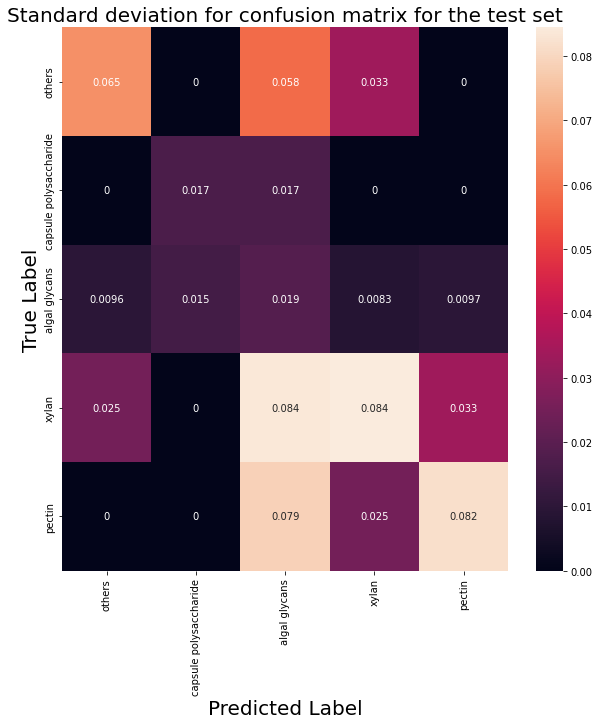

In [76]:
# make the plot
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df_cm_std, annot = True)
plt.title("Standard deviation for confusion matrix for the test set", fontsize = 20)
plt.xlabel("Predicted Label", fontsize = 20)
plt.ylabel("True Label", fontsize = 20)
plt.show()


In [81]:
# average standard errors
np.diag(df_cm_std).mean()

0.05331679059002199

In [82]:
np.diag(df_cm).mean().round(2)

0.75

In [90]:
overall_df = pd.DataFrame({"Balanced_Accuracy": np.diag(df_cm).mean().round(2), 
                          "Balanced_Std_Error": np.diag(df_cm_std).mean().round(2)}, index = [0])

In [91]:
overall_df

Balanced_Accuracy  Balanced_Std_Error
0               0.75                0.05

In [78]:
combo.reindex(data.index)

sig_gene_seq  \
0                                                                                         GH1,8.A.49,CE2,GH130,GH130,3.A.1,3.A.1,SBP_bac_1,LacI,GH36,GH113   
1                                                                                                                                                     GH16   
2                                                                                                                                      GH30_8,GH43_16|CBM6   
3                                                                                                                                                4.A.1,GH1   
4                                                                                                                                                 GH94,GH3   
..                                                                                                                                                     ...   
649  GH2,2.A.21,3.D.1,GH96,GH96,2.A.1,GH50,GH50,GH50,GH29,SBP_bac_1,TrmB,1.B.14,GntR,GH50,1.B.14,GH86,3.A.1,3.A.1,3.A.1,3.A.1,PfkB,GH117|GH117,Pyr_redox_2   
650                                                                                         GH16_16,HTH_8,PfkB,GH2,GH117|GH117,3.A.1,3.A.1,3.A.1,LacI,GH50   
651           GerE,1.B.14,GH144,GH144,CE1,GH3,BLUF,PL6|PL6_1,PL12,PL6|PL6_1,PL17_2|PL17,AraC_binding,1.B.14,8.A.46,GntR,2.A.1,LacI,PfkB,TPR_2,Response_reg   
652                                                                                                                                    1.B.14,PL7,PL7,GntR   
653                                                                                                                                       GH166,GT4,2.A.66   

    high_level_substr  
0              others  
1              others  
2               xylan  
3              others  
4              others  
..                ...  
649     algal glycans  
650     algal glycans  
651     algal glycans  
652     algal glycans  
653            others  

[654 rows x 2 columns]